# Data Cleaning and Exploration

## Initialization

In [67]:
#Python Data Analysis imports
import pandas as pd
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#To grab stock data
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
from datetime import datetime as dt
import datetime
import calendar

# Caching
import requests_cache

In [68]:
# American Airlines Group Inc. (AAL), # Delta Air Lines, Inc. (DAL)
stock_names = {'AAL': 'American Airlines Group Inc.', 'DAL': 'Delta Air Lines, Inc.', 'LUV': 'Southwest Airlines', 'FB': 'Facebook', 'SBUX': 'Starbucks'}
airline_stocks = ['AAL', 'DAL', 'LUV', 'FB', 'SBUX']
AAL, DAL, LUV, FB, SBUX = None, None, None, None, None
start = dt(2010, 1, 1)
end = dt(2020, 1, 1)

Making the same request repeatedly can use a lot of bandwidth, slow down your code and may result in your IP being banned.
We might not need to cache...

In [69]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [70]:
def load_stocks(stocks, start, end):
    """
    Loads stock data from Yahoo Finance.
    """
    for stock in stocks:
        try:
            globals()[stock] = web.DataReader(stock, 'yahoo', start, end, session=session) # default interval is 1day
        except Exception as  e:
            print('Error downloading: ' + stock, "error: ", e)
            return
    print('Data loaded successfully.')

In [71]:
load_stocks(airline_stocks, start, end)

Data loaded successfully.


## Data Cleaning

Features - Airline Stocks:
- High - High price of the stock
- Low - Low price of the stock
- Open - Open price of the stock
- Close - Close price of the stock
- Volume - Volume of the stock

### Airline Stocks

In [72]:
print(AAL.shape)
AAL.head()

(2516, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,4.94,4.66,4.84,4.77,9837300.0,4.496876
2010-01-05,5.37,4.71,4.79,5.31,25212000.0,5.005957
2010-01-06,5.38,5.00,5.19,5.09,16597900.0,4.798555
2010-01-07,5.43,5.05,5.06,5.24,14033400.0,4.939965
2010-01-08,5.43,5.06,5.27,5.14,12760000.0,4.845693


In [73]:
print(DAL.shape)
DAL.head()

(2516, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,11.43,10.95,11.22,11.22,14482500.0,9.966127
2010-01-05,12.34,11.29,11.32,12.10,25066000.0,10.747786
2010-01-06,12.24,11.85,11.99,12.11,14980700.0,10.756670
2010-01-07,12.86,12.05,12.06,12.69,19814500.0,11.271851
2010-01-08,12.85,12.05,12.62,12.47,24589200.0,11.076440


In [74]:
print(LUV.shape)
LUV.head()

(2516, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,11.46,11.09,11.40,11.18,9625000.0,10.363511
2010-01-05,11.79,11.20,11.25,11.77,13355100.0,10.910420
2010-01-06,11.79,11.38,11.76,11.42,10523900.0,10.585979
2010-01-07,11.74,11.27,11.39,11.59,10055100.0,10.743566
2010-01-08,11.64,11.23,11.54,11.33,7894500.0,10.502551


In [75]:
print(FB.shape)
FB.head()

(1917, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [76]:
print(SBUX.shape)
SBUX.head()

(2516, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,11.665,11.455,11.66,11.525,16370000.0,9.428394
2010-01-05,12.000,11.445,11.48,11.795,30058800.0,9.649279
2010-01-06,11.810,11.630,11.74,11.710,14209600.0,9.579743
2010-01-07,11.765,11.595,11.64,11.680,10256000.0,9.555197
2010-01-08,11.800,11.595,11.60,11.640,10274800.0,9.522477


Check for missing values

In [77]:
def show_airline_stock_missing_values():
    missing_values = pd.DataFrame(index=["High", "Low", "Open", "Close", "Volume"], columns=airline_stocks)
    for stock in airline_stocks:
        missing_values[stock] = globals()[stock].isnull().sum()
    return missing_values

show_airline_stock_missing_values()

,AAL,DAL,LUV,FB,SBUX
High,0,0,0,0,0
Low,0,0,0,0,0
Open,0,0,0,0,0
Close,0,0,0,0,0
Volume,0,0,0,0,0


In [78]:
def airline_stock_extract_dates():
    for stock in airline_stocks:
        df_stock = globals()[stock]
        df_stock['Day'], df_stock['Month'], df_stock['Year'] = df_stock.index.day, df_stock.index.month, df_stock.index.year

airline_stock_extract_dates()
AAL.head(2)

,High,Low,Open,Close,Volume,Adj Close,Day,Month,Year
Date,,,,,,,,,
2010-01-04,4.94,4.66,4.84,4.77,9837300.0,4.496876,4,1,2010
2010-01-05,5.37,4.71,4.79,5.31,25212000.0,5.005957,5,1,2010


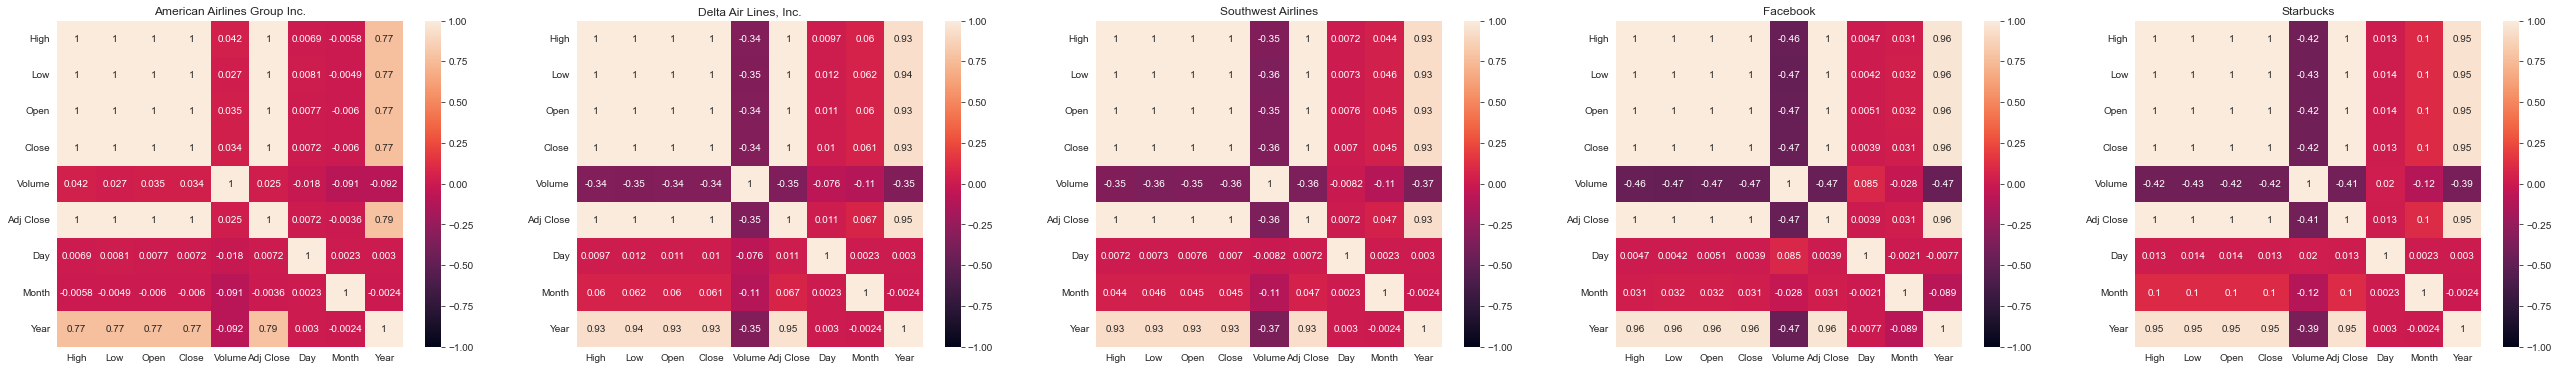

In [79]:
def airline_stock_corr():
    fig, ax = plt.subplots(1, len(airline_stocks), figsize=(9*len(airline_stocks), 6))
    for i, stock in enumerate(airline_stocks):
        ax[i].set_title(stock_names[stock])
        sns.heatmap(globals()[stock].corr(), vmin=-1, vmax=1,  ax=ax[i], annot=True)

airline_stock_corr()

TODO - No need to remove any columns?

### Other Stocks

...

## Exploratory Data Analysis

In [80]:
def open_close_prices_per_airline(years:list):
    fig, ax = plt.subplots(1, len(airline_stocks), figsize=(7*len(airline_stocks), 6))
    for i, stock in enumerate(airline_stocks):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]

        ax[i].set_title(stock_names[stock] + " - " + ",".join(str(year) for year in years))
        df_stock.plot(y=['Open','Close'], ax=ax[i])

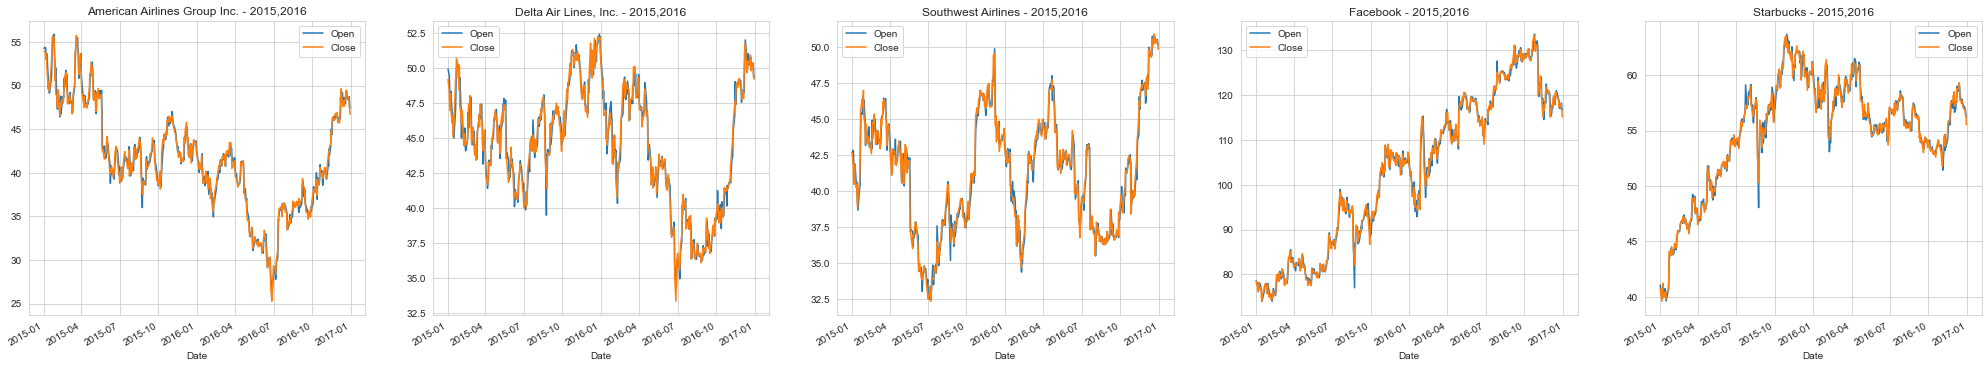

In [81]:
open_close_prices_per_airline([2015, 2016])

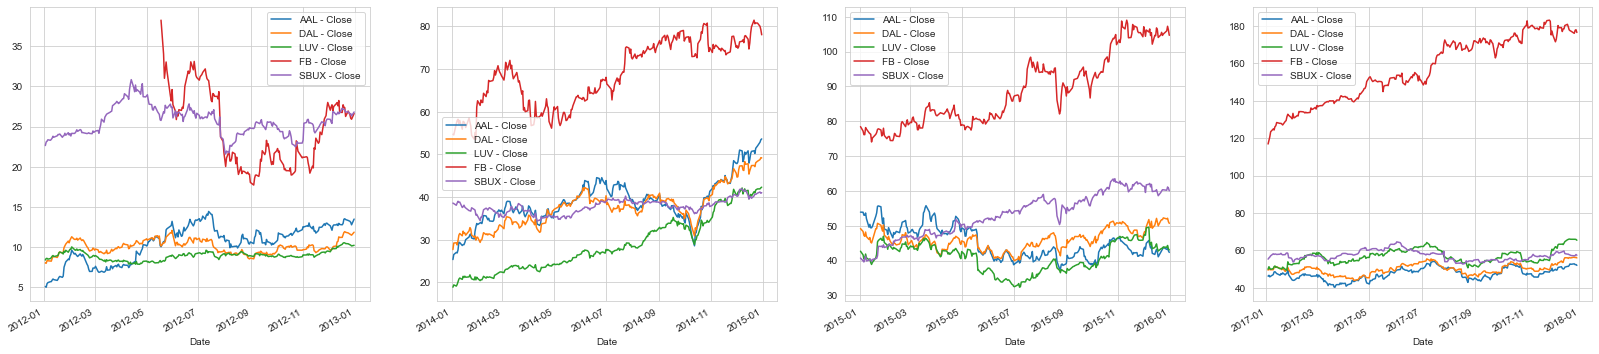

In [82]:
# now we will match stock increases and decreases, per year
def airline_stock_price_per_year(features:list = ['Open'], years:list = [2015]):
    fig, ax = plt.subplots(1, len(years), figsize=(7*len(years), 6))
    for i, year in enumerate(years):
        for j, stock in enumerate(airline_stocks):
            df_stock = globals()[stock]
            df_stock = df_stock.loc[df_stock["Year"] == year]

            # ax[i].set_title(stock_names[stock] + " - " + str(year))
            df_stock.plot(y=features, ax=ax[i], label=[f"{stock} - {f}" for f in features])

airline_stock_price_per_year(features=['Close'], years=[2012, 2014, 2015, 2017])

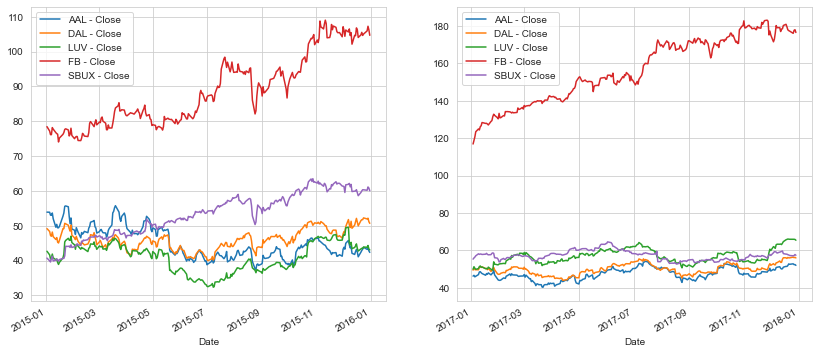

In [83]:
airline_stock_price_per_year(features=['Close'], years=[2015, 2017])

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose
def airline_stock_seasonality_and_trends_decompose(feature='Open', model='additive', freq='B', period=1, years=[2015, 2016]):
    fig, ax = plt.subplots(4, len(airline_stocks), figsize=(20, 15))
    for i, stock in enumerate(airline_stocks):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]
        df_stock = df_stock.asfreq(freq).dropna()
        df_stock_decompose = seasonal_decompose(df_stock[feature], model=model, period=period)

        # ax[0, i].plot(df_stock[feature].rolling(period).mean())
        
        ax[0, i].plot(df_stock[feature])
        ax[0, i].set_title(f"Observed - ({stock_names[stock]})")
        ax[0, i].tick_params(axis='x', labelrotation=45)

        ax[1, i].plot(df_stock_decompose.trend)
        ax[1, i].set_title(f"Trend - ({stock_names[stock]})")
        ax[1, i].tick_params(axis='x',labelrotation=45)

        ax[2, i].plot(df_stock_decompose.seasonal)
        ax[2, i].set_title(f"Seasonal - ({stock_names[stock]})")
        ax[2, i].tick_params(axis='x',labelrotation=45)

        ax[3, i].plot(df_stock_decompose.resid)
        ax[3, i].set_title(f"Residual - ({stock_names[stock]})")
        ax[3, i].tick_params(axis='x',labelrotation=45)


        # adjusting positions of the subplots
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


In [102]:
years = list(range(start.year, end.year + 1))
periods = [year for year in AAL.index.year.value_counts()]
period = np.mean(periods).astype(int)
period

251

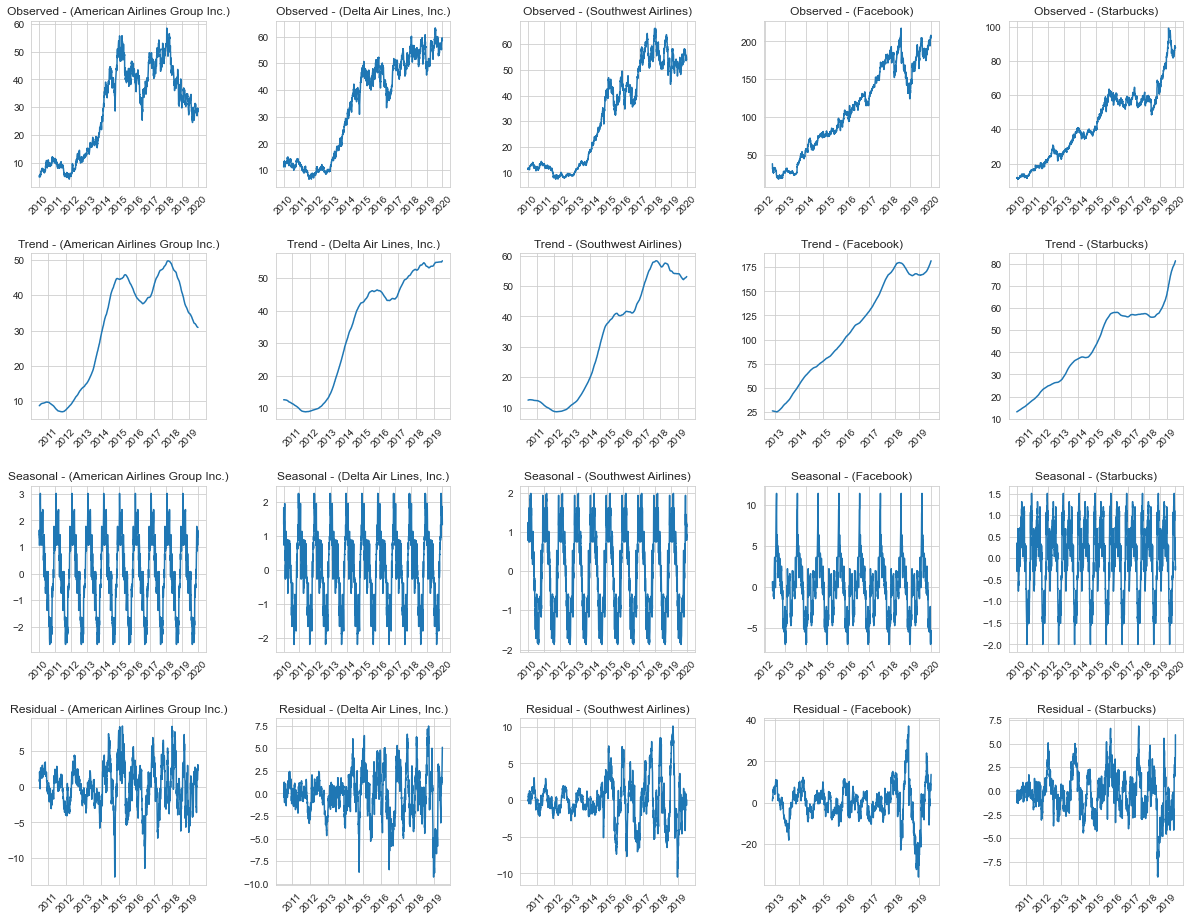

In [103]:
decompose_res = airline_stock_seasonality_and_trends_decompose("Close", model="additive", freq="B", period=period, years=years)

In [87]:
from statsmodels.tsa.seasonal import STL
def airline_stock_seasonality_and_trends(feature='Open', model='additive', freq='B', period=1, years=[2015, 2016]):
    decompostion = []
    fig, ax = plt.subplots(4, len(airline_stocks), figsize=(25, 20))
    for i, stock in enumerate(airline_stocks):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]
        df_stock = df_stock.asfreq(freq).dropna()

        res = STL(df_stock[feature], seasonal=13, period=period).fit()


        ax[0, i].plot(df_stock[feature])
        ax[0, i].set_title(f"Observed - ({stock_names[stock]})")
        ax[0, i].tick_params(axis='x', labelrotation=45)
        # xticks(rotation=45, ha='right')

        ax[1, i].plot(res.trend)
        ax[1, i].set_title(f"Trend - ({stock_names[stock]})")
        ax[1, i].tick_params(axis='x',labelrotation=45)

        ax[2, i].plot(res.seasonal)
        ax[2, i].set_title(f"Seasonal - ({stock_names[stock]})")
        ax[2, i].tick_params(axis='x',labelrotation=45)

        resid_mu = res.resid.mean()
        resid_dev = res.resid.std()

        lower = resid_mu - 3*resid_dev
        upper = resid_mu + 3*resid_dev

        anomalies = df_stock[feature][(res.resid < lower) | (res.resid > upper)]
        
        ax[3, i].plot(res.resid)
        ax[3, i].fill_between([dt(min(years),1,1), dt(max(years)+1,1,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
        ax[3, i].set_title(f"Residual - ({stock_names[stock]})")
        ax[3, i].tick_params(axis='x',labelrotation=45)

        # adjusting positions of the subplots
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


        decompostion.append((stock, res, anomalies))
    return decompostion

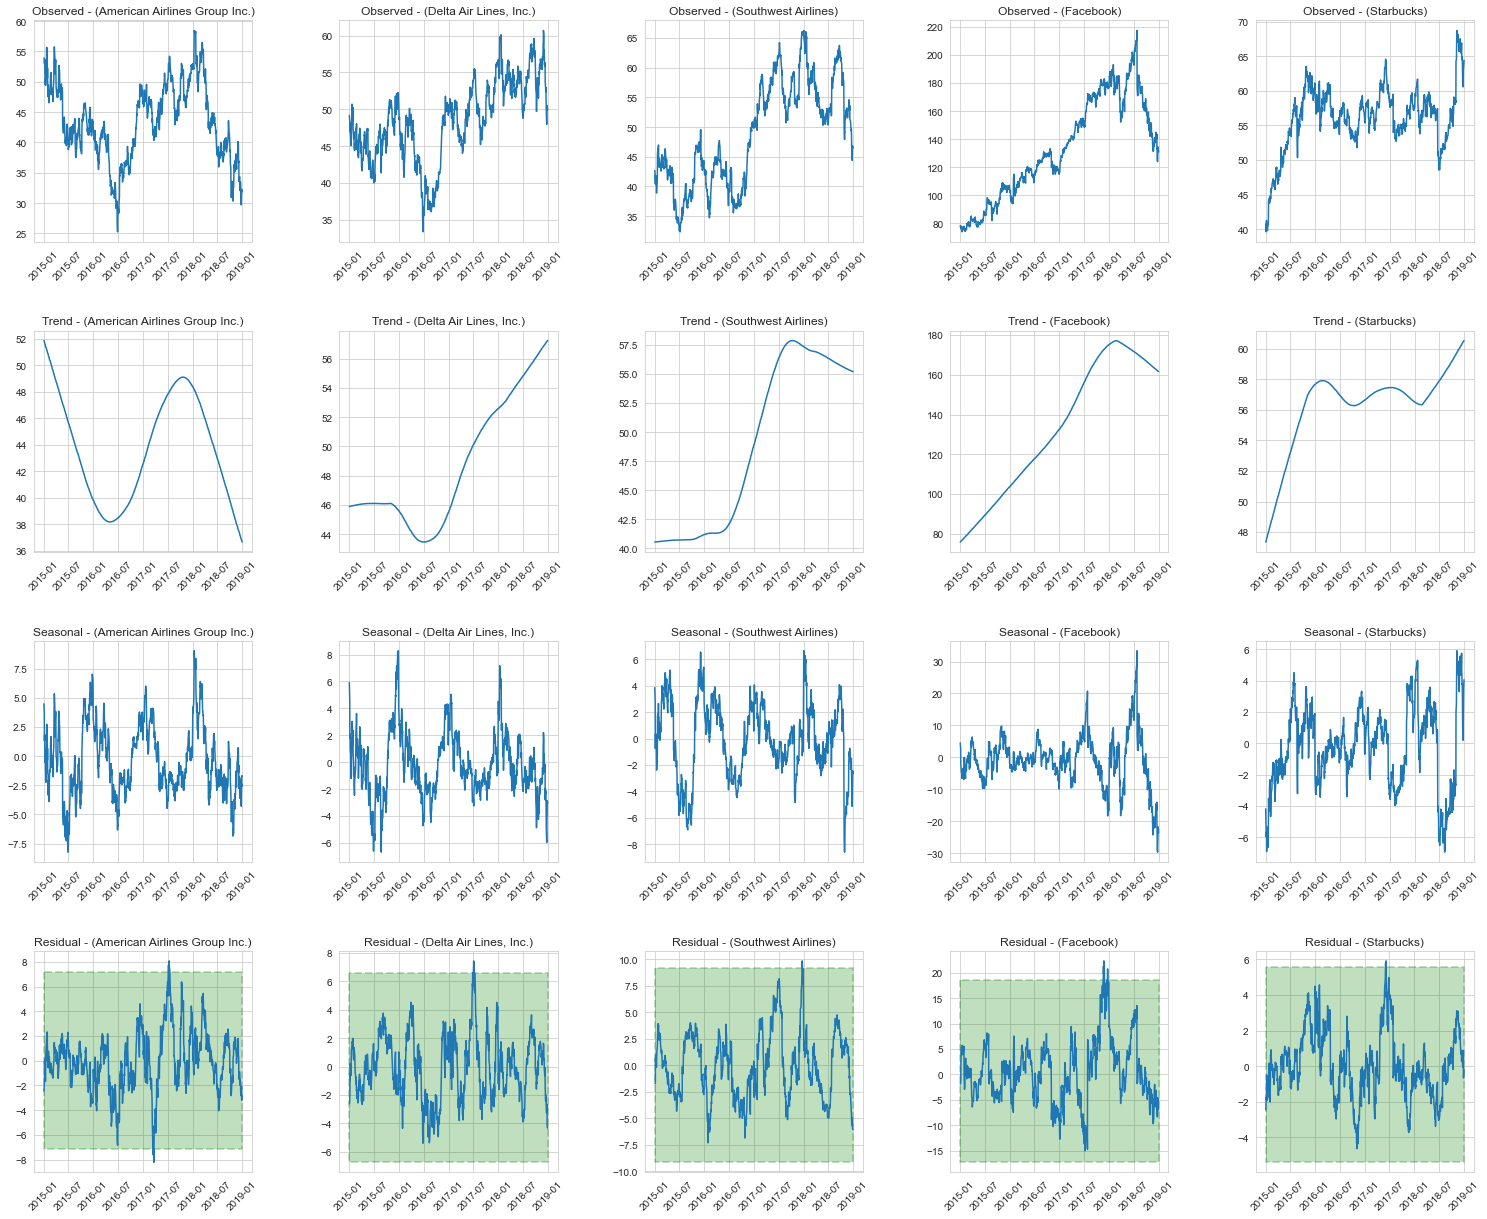

In [88]:
result = airline_stock_seasonality_and_trends("Close", model="additive", freq="B", period=period, years=[2015, 2016, 2017, 2018])

Time series looks like its seasonal, we will check by performing (Augmented Dickey-Fuller) test and KPSS (Kwiatkowski–Phillips–Schmidt–Shintests) tests

Fjerne anomolies?

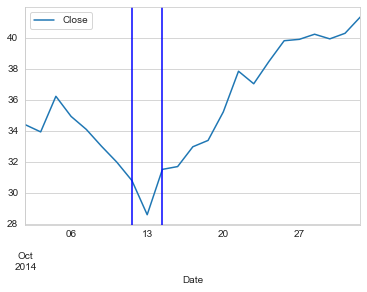

In [89]:
AAL.loc[(AAL["Year"] == 2014) & (AAL["Month"] == 10)].plot(y=["Close"])
plt.axvline(x=dt(2014, 10, 10), color='b', label='axvline - full height')
plt.axvline(x=dt(2014, 10, 14), color='b', label='axvline - full height')

In [90]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_test(stock_close_price, period):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(period).mean()
    rolling_std_dev = stock_close_price.rolling(period).std()
  
    # # Plotting the statistics:
    # plt.figure(figsize=(24,6))
    # plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    # plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    # plt.plot(stock_close_price, color='red',label='Original Time Series')
    # plt.legend(loc='best')
    # plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("\nKPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

In [91]:
stationarity_test(DAL['Close'], period=period)

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -0.868612
p-value: 0.798133
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 7.636662
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [570]:
period

251

In [572]:
diffData = DAL-DAL.shift(2)
diffData.dropna(inplace=True)
adfuller(diffData['Close'], autolag='AIC')

(-11.443760742546543,
 6.088858951994535e-21,
 27,
 2486,
 {'1%': -3.4329831717881003,
  '5%': -2.8627033184297384,
  '10%': -2.5673892799386944},
 5295.174267055398)

TODO:
    p-values, what is correct?
    stationarity, shift by 1 and check adfuller and kpss
    add with twitter stock...

## Testing Stuff

Need To read up on this stuff.,..
- https://medium.com/quantjam/introduction-to-time-series-trend-decomposition-with-python-b54a29f8e038
- https://medium.com/quantjam/exploring-market-seasonality-trends-19a91381c0fe

<AxesSubplot:xlabel='Date'>

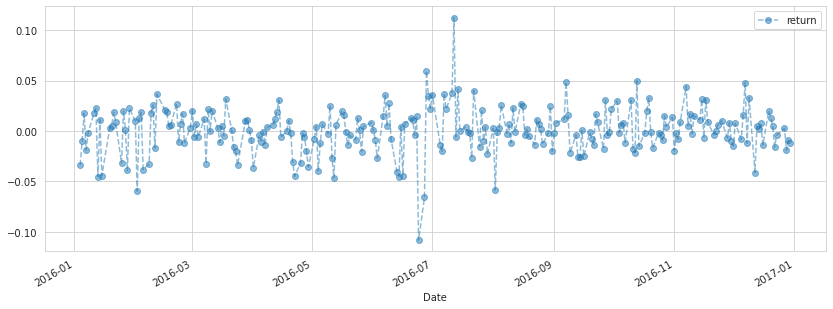

In [407]:
AAL2 = AAL.copy()
AAL2["return"] = AAL2["Close"].pct_change()
AAL2.loc[AAL2["Year"] == 2016]["return"].plot(figsize=(14,5),legend=True,linestyle='--',marker='o', alpha=0.5)

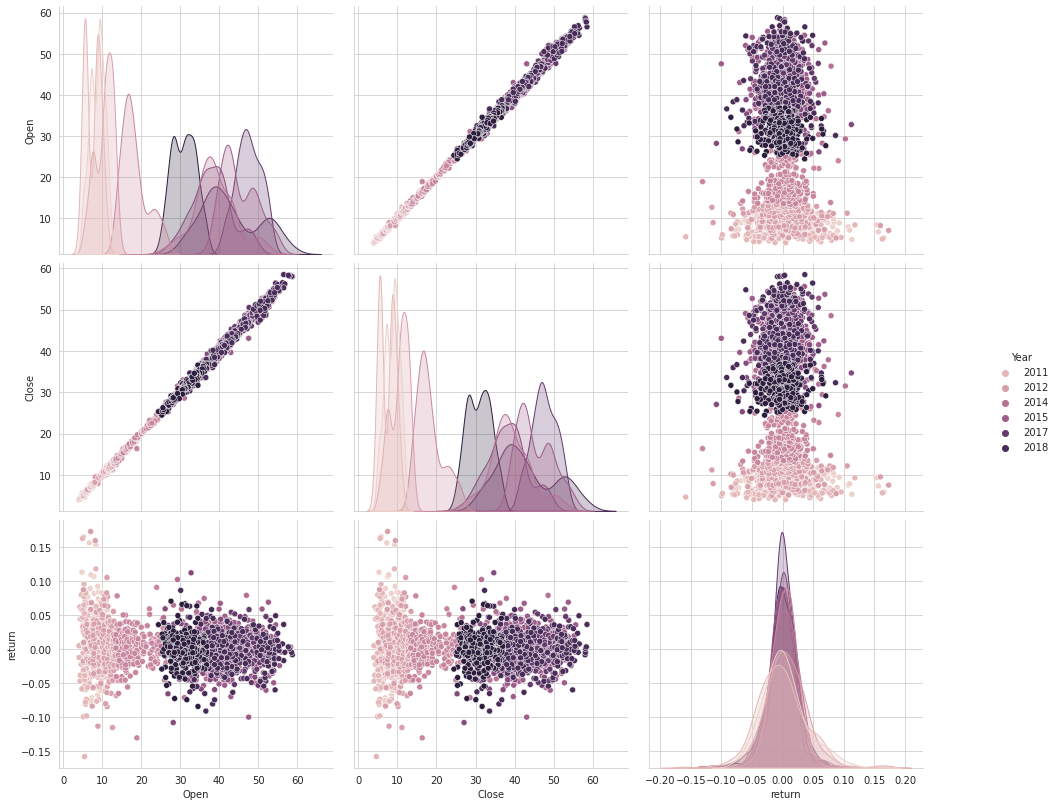

In [408]:
g = sns.pairplot(AAL2.dropna(), vars=["Open", "Close", "return"], kind="scatter", hue="Year")
g.fig.set_figwidth(15.27)
g.fig.set_figheight(11.7)

Stationary data? - https://towardsdatascience.com/forecasting-time-series-data-stock-price-analysis-324bcc520af5

In [409]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # # Plotting the statistics:
    # plt.figure(figsize=(24,6))
    # plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    # plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    # plt.plot(stock_close_price, color='red',label='Original Time Series')
    # plt.legend(loc='best')
    # plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("\nKPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(AAL['Close'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.683928
p-value: 0.439412
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 5.823907
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.1_4/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Looks like our data is not stationary, is this bad for arima?

In [410]:
test_period = period
test_period

251

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -2.450102
p-value: 0.128092
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.699399
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.1_4/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.1_4/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


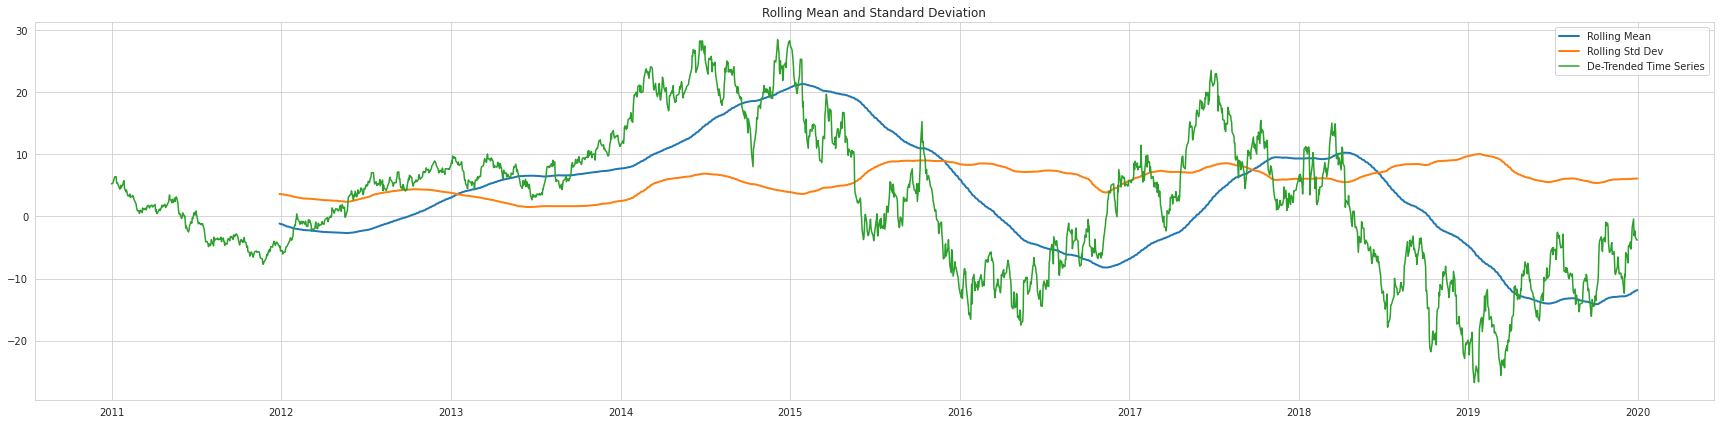

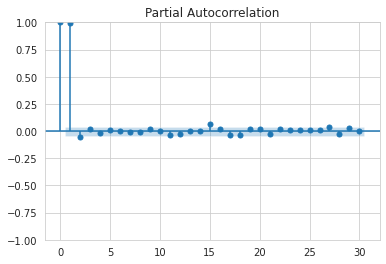

In [411]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
AAL['Close_Detrend'] = (AAL['Close'] - AAL['Close'].shift(test_period))

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(test_period).mean()
    rolling_std_dev = stock_close_price.rolling(test_period).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(AAL['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(AAL['Close_Detrend'].dropna(), lags=30)

Save the stocks to csv file

In [358]:
def Save_Stock_Data(path="data/"):
    for stock in airline_stocks:
        df_stock = globals()[stock]
        df_stock.to_csv(f"{path}{stock}.csv")
Save_Stock_Data()